In [1]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels
# y_test.shape, y_val.shape, y_train.shape
# X_train.shape, X_train.dtype, X_val.shape, X_val.dtype, X_test.shape, X_test.dtype

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
# Pre-processing: normalizing
def normalize(X):
    # max scale for images 255= 2**8= 8 bit grayscale for each channel
    return (X - X.mean(axis=0)) #/ X.std(axis=0)

X_train, X_val, X_test = normalize(X=X_train), normalize(X=X_val), normalize(X=X_test)

In [3]:
# Model
import impl.layer as l # or from impl.layer import *
from impl.loss import * # import all functions from impl.loss file # import impl.loss as loss_func
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        self.L = L # number of layers or depth
        self.losses = {'train':[], 'valid':[], 'valid_acc':[]}
        
        # The adaptive/learnable/updatable random feedforward
        self.model = []
        self.W_fixed = []
        self.grads = []
        self.ys_prev = []
        low, high = -1, 1
        
        # Input layer: weights/ biases
        m = dict(W=np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.), b=np.zeros((1, H)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.)
        self.W_fixed.append(m)
        # Input layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
        # Previous output layer
        self.ys_prev.append(0.0)

        # Hidden layers: weights/ biases
        m_L = []
        for _ in range(L):
            m = dict(W=np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, H)))
            m_L.append(m)
        self.model.append(m_L)
        # Fixed feedback weight
        m_L = []
        for _ in range(L):
            m = np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.)
            m_L.append(m)
        self.W_fixed.append(m_L)
        # Hidden layer: gradients
        grad_L = []
        for _ in range(L):
            grad_L.append({key: np.zeros_like(val) for key, val in self.model[1][0].items()})
        self.grads.append(grad_L)
        # Previous output layer
        ys_prev_L = []
        for _ in range(L):
            ys_prev_L.append(0.0)
        self.ys_prev.append(ys_prev_L)
        
        # Output layer: weights/ biases
        m = dict(W=np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, C)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.)
        self.W_fixed.append(m)
        # Outout layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        # Previous output layer
        self.ys_prev.append(0.0)
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache, W_fixed):
        W, X = cache

        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn
        
#         dX = dout @ W.T # Backprop
        dX = dout @ W_fixed.T # fb alignment

        return dX, dW, db

    def train_forward(self, X, train):
        caches, ys = [], []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b']) # X_1xD, y_1xc
        y, nl_cache = l.tanh_forward(X=y)
        if train:
            caches.append((fc_cache, nl_cache))
        ys.append(y) # ys[0]
        X = y.copy() # pass to the next layer
        
        # Hidden layers
        fc_caches, nl_caches, ys_L = [], [], []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y, nl_cache = l.tanh_forward(X=y)
            ys_L.append(y) # ys[1][layer]
            X = y.copy() # pass to next layer
            if train:
                fc_caches.append(fc_cache)
                nl_caches.append(nl_cache)
        if train:
            caches.append((fc_caches, nl_caches)) # caches[1]            
        ys.append(ys_L) # ys[1]            
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        if train:
            caches.append(fc_cache)
        ys.append(y) # ys[2]

        return ys, caches # for backpropating the error

    def loss_function(self, y, y_train):
        
        loss = cross_entropy(y, y_train) # softmax is included
        dy = dcross_entropy(y, y_train) # dsoftmax is included
        
        return loss, dy
        
    def train_backward(self, dy, caches, ys):
        grads, ys_prev = self.grads, self.ys_prev # initialized by Zero in every iteration/epoch
        
        # Output layer
        fc_cache = caches[2]
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[2])
        dy = dX.copy()
        grads[2]['W'] = dW
        grads[2]['b'] = db

        # Hidden layer
        fc_caches, nl_caches = caches[1]
        for layer in reversed(range(self.L)):
            dy *= ys[1][layer] - ys_prev[1][layer] # temporal diff instead of differentiable function
#             dy = l.tanh_backward(cache=nl_caches[layer], dout=dy) # diffable function
            dX, dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer], W_fixed=self.W_fixed[1][layer])
            dy = dX.copy()
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
        
        # Input layer
        fc_cache, nl_cache = caches[0]
        dy *= ys[0] - ys_prev[0] # temporal diff instead of differentiable function
#         dy = l.tanh_backward(cache=nl_cache, dout=dy) # diffable function
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[0])
        grads[0]['W'] = dW
        grads[0]['b'] = db

        return dX, grads
    
    def test(self, X):
        ys_logit, _ = self.train_forward(X, train=False)
        y_logit = ys_logit[2] # last layer
        
        # if self.mode == 'classification':
        y_prob = l.softmax(y_logit) # for accuracy == acc
        y_pred = np.argmax(y_prob, axis=1) # for loss ==err
        
        return y_pred, y_logit
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def sgd(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            ys, caches = self.train_forward(X_mini, train=True)
            loss, dy = self.loss_function(ys[2], y_mini)
            _, grads = self.train_backward(dy, caches, ys) # ys[0], ys[1] and ys_prev are used for backprop
            self.ys_prev = ys # for next iteration or epoch learning dW and db
            self.losses['train'].append(loss)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]

            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
                
            # Validate the updated model
            y_pred, y_logit = self.test(X_val)
            valid_loss, _ = self.loss_function(y_logit, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val) # confusion matrix
            self.losses['valid_acc'].append(valid_acc)
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{} train loss: {:.4f} valid loss: {:.4f}, valid accuracy: {:.4f}'.format(
                    iter, loss, valid_loss, valid_acc))

        # Test the final model
        y_pred, y_logit = nn.test(X_test)
        loss, _ = self.loss_function(y_logit, y_test) # softmax is included in entropy loss function
        acc = np.mean(y_pred == y_test)
        print('Last iteration - Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.format(
            acc.mean(), acc.std(), loss))

In [4]:
# Hyper-parameters
n_iter = 100000 # number of epochs
alpha = 1e-3 # learning_rate
mb_size = 50 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 100 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 2 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.sgd(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-100 train loss: 2.3225 valid loss: 2.3122, valid accuracy: 0.0780
Iter-200 train loss: 2.3230 valid loss: 2.3113, valid accuracy: 0.0786
Iter-300 train loss: 2.3076 valid loss: 2.3104, valid accuracy: 0.0798
Iter-400 train loss: 2.3239 valid loss: 2.3096, valid accuracy: 0.0812
Iter-500 train loss: 2.3215 valid loss: 2.3086, valid accuracy: 0.0822
Iter-600 train loss: 2.3129 valid loss: 2.3077, valid accuracy: 0.0842
Iter-700 train loss: 2.3226 valid loss: 2.3069, valid accuracy: 0.0850
Iter-800 train loss: 2.3240 valid loss: 2.3060, valid accuracy: 0.0864
Iter-900 train loss: 2.3031 valid loss: 2.3051, valid accuracy: 0.0860
Iter-1000 train loss: 2.3052 valid loss: 2.3042, valid accuracy: 0.0872
Iter-1100 train loss: 2.3056 valid loss: 2.3033, valid accuracy: 0.0876
Iter-1200 train loss: 2.3084 valid loss: 2.3025, valid accuracy: 0.0888
Iter-1300 train loss: 2.3260 valid loss: 2.3016, valid accuracy: 0.0894
Iter-1400 train loss: 2.2976 valid loss: 2.3007, valid accuracy: 0.0916
I

Iter-11500 train loss: 2.2507 valid loss: 2.2207, valid accuracy: 0.2964
Iter-11600 train loss: 2.2147 valid loss: 2.2199, valid accuracy: 0.2976
Iter-11700 train loss: 2.1734 valid loss: 2.2192, valid accuracy: 0.2992
Iter-11800 train loss: 2.1807 valid loss: 2.2184, valid accuracy: 0.2994
Iter-11900 train loss: 2.2230 valid loss: 2.2177, valid accuracy: 0.3006
Iter-12000 train loss: 2.1924 valid loss: 2.2170, valid accuracy: 0.3016
Iter-12100 train loss: 2.2275 valid loss: 2.2163, valid accuracy: 0.3026
Iter-12200 train loss: 2.1893 valid loss: 2.2155, valid accuracy: 0.3038
Iter-12300 train loss: 2.2254 valid loss: 2.2148, valid accuracy: 0.3040
Iter-12400 train loss: 2.2061 valid loss: 2.2141, valid accuracy: 0.3062
Iter-12500 train loss: 2.2358 valid loss: 2.2134, valid accuracy: 0.3066
Iter-12600 train loss: 2.2011 valid loss: 2.2127, valid accuracy: 0.3078
Iter-12700 train loss: 2.2345 valid loss: 2.2120, valid accuracy: 0.3094
Iter-12800 train loss: 2.2300 valid loss: 2.2113, v

Iter-22800 train loss: 2.1208 valid loss: 2.1451, valid accuracy: 0.3716
Iter-22900 train loss: 2.1134 valid loss: 2.1445, valid accuracy: 0.3728
Iter-23000 train loss: 2.1234 valid loss: 2.1439, valid accuracy: 0.3732
Iter-23100 train loss: 2.2036 valid loss: 2.1433, valid accuracy: 0.3746
Iter-23200 train loss: 2.1445 valid loss: 2.1427, valid accuracy: 0.3746
Iter-23300 train loss: 2.1534 valid loss: 2.1421, valid accuracy: 0.3754
Iter-23400 train loss: 2.1492 valid loss: 2.1415, valid accuracy: 0.3766
Iter-23500 train loss: 2.1394 valid loss: 2.1409, valid accuracy: 0.3776
Iter-23600 train loss: 2.1278 valid loss: 2.1403, valid accuracy: 0.3780
Iter-23700 train loss: 2.1405 valid loss: 2.1397, valid accuracy: 0.3780
Iter-23800 train loss: 2.1283 valid loss: 2.1391, valid accuracy: 0.3776
Iter-23900 train loss: 2.0992 valid loss: 2.1385, valid accuracy: 0.3772
Iter-24000 train loss: 2.1543 valid loss: 2.1379, valid accuracy: 0.3774
Iter-24100 train loss: 2.1383 valid loss: 2.1373, v

Iter-34100 train loss: 2.1510 valid loss: 2.0808, valid accuracy: 0.4004
Iter-34200 train loss: 2.0582 valid loss: 2.0803, valid accuracy: 0.4002
Iter-34300 train loss: 2.1457 valid loss: 2.0797, valid accuracy: 0.4004
Iter-34400 train loss: 2.1362 valid loss: 2.0792, valid accuracy: 0.4004
Iter-34500 train loss: 2.1441 valid loss: 2.0787, valid accuracy: 0.4008
Iter-34600 train loss: 2.1001 valid loss: 2.0782, valid accuracy: 0.4014
Iter-34700 train loss: 2.1189 valid loss: 2.0777, valid accuracy: 0.4016
Iter-34800 train loss: 2.0263 valid loss: 2.0771, valid accuracy: 0.4022
Iter-34900 train loss: 2.1581 valid loss: 2.0766, valid accuracy: 0.4028
Iter-35000 train loss: 2.1361 valid loss: 2.0761, valid accuracy: 0.4034
Iter-35100 train loss: 2.0773 valid loss: 2.0756, valid accuracy: 0.4032
Iter-35200 train loss: 2.0991 valid loss: 2.0751, valid accuracy: 0.4034
Iter-35300 train loss: 2.0935 valid loss: 2.0746, valid accuracy: 0.4030
Iter-35400 train loss: 2.1405 valid loss: 2.0740, v

Iter-45400 train loss: 2.0199 valid loss: 2.0251, valid accuracy: 0.4218
Iter-45500 train loss: 2.0047 valid loss: 2.0247, valid accuracy: 0.4220
Iter-45600 train loss: 1.9664 valid loss: 2.0242, valid accuracy: 0.4220
Iter-45700 train loss: 2.0389 valid loss: 2.0237, valid accuracy: 0.4228
Iter-45800 train loss: 2.0481 valid loss: 2.0233, valid accuracy: 0.4222
Iter-45900 train loss: 1.9823 valid loss: 2.0228, valid accuracy: 0.4226
Iter-46000 train loss: 2.0144 valid loss: 2.0224, valid accuracy: 0.4226
Iter-46100 train loss: 2.0110 valid loss: 2.0220, valid accuracy: 0.4220
Iter-46200 train loss: 2.0102 valid loss: 2.0215, valid accuracy: 0.4224
Iter-46300 train loss: 2.0583 valid loss: 2.0210, valid accuracy: 0.4226
Iter-46400 train loss: 2.0477 valid loss: 2.0206, valid accuracy: 0.4220
Iter-46500 train loss: 2.0284 valid loss: 2.0201, valid accuracy: 0.4226
Iter-46600 train loss: 2.0086 valid loss: 2.0197, valid accuracy: 0.4230
Iter-46700 train loss: 2.0902 valid loss: 2.0192, v

Iter-56700 train loss: 1.9706 valid loss: 1.9764, valid accuracy: 0.4316
Iter-56800 train loss: 2.0013 valid loss: 1.9760, valid accuracy: 0.4328
Iter-56900 train loss: 1.9436 valid loss: 1.9756, valid accuracy: 0.4330
Iter-57000 train loss: 2.0298 valid loss: 1.9752, valid accuracy: 0.4336
Iter-57100 train loss: 2.0452 valid loss: 1.9748, valid accuracy: 0.4330
Iter-57200 train loss: 2.0251 valid loss: 1.9744, valid accuracy: 0.4334
Iter-57300 train loss: 1.9925 valid loss: 1.9740, valid accuracy: 0.4338
Iter-57400 train loss: 2.0097 valid loss: 1.9736, valid accuracy: 0.4342
Iter-57500 train loss: 2.0003 valid loss: 1.9733, valid accuracy: 0.4340
Iter-57600 train loss: 2.0236 valid loss: 1.9729, valid accuracy: 0.4336
Iter-57700 train loss: 1.9268 valid loss: 1.9725, valid accuracy: 0.4336
Iter-57800 train loss: 1.9591 valid loss: 1.9721, valid accuracy: 0.4340
Iter-57900 train loss: 1.9890 valid loss: 1.9717, valid accuracy: 0.4342
Iter-58000 train loss: 1.9647 valid loss: 1.9713, v

Iter-68000 train loss: 2.0025 valid loss: 1.9332, valid accuracy: 0.4442
Iter-68100 train loss: 1.9361 valid loss: 1.9329, valid accuracy: 0.4440
Iter-68200 train loss: 1.9620 valid loss: 1.9325, valid accuracy: 0.4442
Iter-68300 train loss: 1.9550 valid loss: 1.9322, valid accuracy: 0.4440
Iter-68400 train loss: 1.9510 valid loss: 1.9318, valid accuracy: 0.4444
Iter-68500 train loss: 1.8848 valid loss: 1.9314, valid accuracy: 0.4444
Iter-68600 train loss: 2.0139 valid loss: 1.9311, valid accuracy: 0.4440
Iter-68700 train loss: 1.8877 valid loss: 1.9307, valid accuracy: 0.4446
Iter-68800 train loss: 1.9961 valid loss: 1.9304, valid accuracy: 0.4444
Iter-68900 train loss: 1.9468 valid loss: 1.9300, valid accuracy: 0.4446
Iter-69000 train loss: 1.9130 valid loss: 1.9297, valid accuracy: 0.4452
Iter-69100 train loss: 1.9564 valid loss: 1.9293, valid accuracy: 0.4456
Iter-69200 train loss: 1.9337 valid loss: 1.9290, valid accuracy: 0.4450
Iter-69300 train loss: 1.8674 valid loss: 1.9286, v

Iter-79300 train loss: 1.8110 valid loss: 1.8948, valid accuracy: 0.4520
Iter-79400 train loss: 1.8857 valid loss: 1.8945, valid accuracy: 0.4522
Iter-79500 train loss: 1.8933 valid loss: 1.8941, valid accuracy: 0.4524
Iter-79600 train loss: 1.8466 valid loss: 1.8938, valid accuracy: 0.4522
Iter-79700 train loss: 1.9274 valid loss: 1.8935, valid accuracy: 0.4524
Iter-79800 train loss: 1.9037 valid loss: 1.8932, valid accuracy: 0.4526
Iter-79900 train loss: 1.9490 valid loss: 1.8928, valid accuracy: 0.4522
Iter-80000 train loss: 1.8681 valid loss: 1.8925, valid accuracy: 0.4520
Iter-80100 train loss: 1.8814 valid loss: 1.8922, valid accuracy: 0.4520
Iter-80200 train loss: 1.9760 valid loss: 1.8919, valid accuracy: 0.4524
Iter-80300 train loss: 1.9361 valid loss: 1.8915, valid accuracy: 0.4526
Iter-80400 train loss: 1.8886 valid loss: 1.8912, valid accuracy: 0.4528
Iter-80500 train loss: 1.8087 valid loss: 1.8909, valid accuracy: 0.4542
Iter-80600 train loss: 1.8496 valid loss: 1.8905, v

Iter-90600 train loss: 1.9003 valid loss: 1.8601, valid accuracy: 0.4606
Iter-90700 train loss: 2.0386 valid loss: 1.8598, valid accuracy: 0.4608
Iter-90800 train loss: 1.9734 valid loss: 1.8595, valid accuracy: 0.4612
Iter-90900 train loss: 1.8602 valid loss: 1.8593, valid accuracy: 0.4616
Iter-91000 train loss: 1.9350 valid loss: 1.8590, valid accuracy: 0.4604
Iter-91100 train loss: 1.6784 valid loss: 1.8587, valid accuracy: 0.4610
Iter-91200 train loss: 1.8622 valid loss: 1.8584, valid accuracy: 0.4606
Iter-91300 train loss: 1.8269 valid loss: 1.8581, valid accuracy: 0.4608
Iter-91400 train loss: 1.8780 valid loss: 1.8578, valid accuracy: 0.4612
Iter-91500 train loss: 1.8652 valid loss: 1.8575, valid accuracy: 0.4622
Iter-91600 train loss: 1.9312 valid loss: 1.8572, valid accuracy: 0.4626
Iter-91700 train loss: 1.8286 valid loss: 1.8569, valid accuracy: 0.4622
Iter-91800 train loss: 1.8511 valid loss: 1.8566, valid accuracy: 0.4626
Iter-91900 train loss: 1.8932 valid loss: 1.8564, v

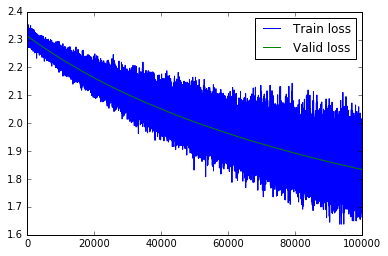

In [5]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.legend()
plt.show()

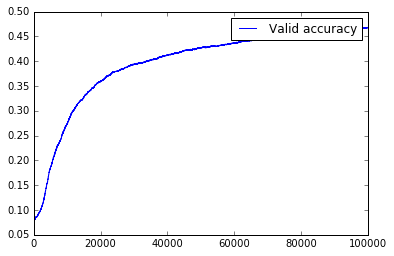

In [6]:
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.legend()
plt.show()